# Foundations of CSS Final Group Project: *Question Goes Here*

TODO: Add link to research poster and report

## Prerequisits

### Install Dependencies

In [1]:
# ATTENTION: pycaret needs PYTHON VERSION 3.11. OR LOWER.If you don't want to bother, most of the analysis can be done without.
!pip install pyreadstat pandas numpy matplotlib wbgapi scipy pycaret seaborn scikit-learn

### Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import shutil
import re
import wbgapi as wb
from scipy import stats
import seaborn as sns

### Decompress Data

In [3]:
with zipfile.ZipFile("data.zip", "r") as zip_ref:
    zip_ref.extractall("data")
 
# For data changes, re-zip data to zip file with python:
# shutil.make_archive("data", 'zip', "data")
# or in the shell with command `zip data.zip data/ -9 -r` (linux)


### Load and Prepare Data

#### Attitudes Data


International Social Survey Programme: Environment I-IV Cumulation. \
ISSP Research Group (2024) \
GESIS, Cologne. \
ZA8793 Data file Version 1.0.0 \
https://doi.org/10.4232/1.14332

See [terms of use](https://www.gesis.org/fileadmin/upload/dienstleistung/daten/umfragedaten/_bgordnung_bestellen/2023-06-30_Nutzungsbedingungen.pdf) (category A) for more information.

The survey data is used in [Long-run trends in partisan polarization of climate policy-relevant attitudes across countries](https://doi.org/10.1080/09644016.2024.2403957) as well which we partly reproduce here.

In [4]:
survey_data_raw_df = pd.read_stata("data/ZA8793_v1-0-0_survey.dta")

There are 145 columns in the dataset.
In the following, we make a selection of relevant ones
and additionally group certain questions into
"support for public" vs "support for individual" action.

In [5]:
# Define mapping functions to support getting survey data in usable format

def extract_integer(x):
    if (type(x) == int): return x
    if (type(x) == float): return int(x)

    return int(x.split('.')[0]) # assuming format like 2. agree somewhat

# The below functions are helpers to make mapping the liker-scale responses (1.-5. (agree or disagree) or 1-4).
# The responses are stretched to values between -2 and 2.
# See in the next cell how it's used.
def likert_scale_to_float(input, invert: bool, shift: float):
    int_val = extract_integer(input)
    if int_val < 0:
        return np.nan;
    else:
        return float(int_val) + shift if invert == False else (float(int_val) + shift) * -1

def likert_scale_to_float_5(input):
    val = likert_scale_to_float(input, invert=False, shift=-3)
    return val if val >= -2 and val <= 2 else np.nan

def likert_scale_to_float_invert_5(input):
    val = likert_scale_to_float(input, invert=False, shift=-3)
    return val if val >= -2 and val <= 2 else np.nan

def likert_scale_to_float_invert_4(input, shift=-2.5):
    val = likert_scale_to_float(input, invert=True, shift=shift) * 4/3
    return val if val >= -2 and val <= 2 else np.nan

def likert_scale_to_float_4(input, invert=False):
    val = likert_scale_to_float(input, invert, shift=-2.5) * 4/3
    return val if val >= -2 and val <= 2 else np.nan



In [6]:
# Comments beginning with letters (abcd) indicate which study have the question, if not all (1993, 2000, 2010, 2020).
# Some mapping comments contain the exact question asked in the survey.
# Detailed explanation of variables can be found here: https://search.gesis.org/research_data/ZA8793#variables|exploredata-ZA8793_VarWRKHRS|0|variable_order|asc

# The below mapping is used to rename the original column names
# and define functions to convert the columns, if necessary.
# Not all of the dataset's questions are mapped (and kept).
# Those are all that seemed vaguely interesting
# but for the main analysis we only consider a subset.
mapping = {
  "cumu_id": {  "name": 'id',
                "mapper": int },
  "year": {     "name": 'year',
                "mapper": extract_integer },
  "country": {  "name": 'country_iso2',
                "mapper": lambda country: re.search(r'^\d+\. ([A-Z]+)-', country).group(1) },
  "AGE": {      "name": 'age',
                "mapper": extract_integer },
  "SEX": {      "name": 'sex',
                "mapper": None },
  "EDUCYRS": {  "name": 'education_years',
                "mapper": lambda year: extract_integer(year) if extract_integer(year) < 30 else -2 },
  'MARITAL': {  "name": 'marital_status',
                "mapper": None },
  "PARTY_LR1": {"name": 'party_lef_right_derived',
                "mapper": likert_scale_to_float_5 },
  "PARTY_LR2": {"name": 'party_lef_right_asked',
                "mapper": likert_scale_to_float_5 },
  "WEIGHT": {   "name": 'regional_weight_factor',
                "mapper": lambda w: 1 if w == "1. No weighting" else w },
  "v3": {       "name": 'environment_most_important',
                "mapper": lambda res: 2 if res and res.startswith('4. The env') else 0},
  "v4": {       "name": 'environment_second_most_important',
                "mapper": lambda res: 2 if res and res.startswith('4. The env') else 0},
  "v5": {       "name": 'most_important_env_problem',
                "mapper": lambda res: 2 if res.startswith('7.') else 1.5 if res.startswith('1.5') else 1 if res.startswith('9.') else 0}, #`7. Climate Change`, `1. air pollution`, `9. Using up our natural resources`
  "v11": {      "name": 'science_solves_env_problems',
                "mapper": likert_scale_to_float_invert_5 },
  "v12": {      "name": 'worry_too_much_about_env_not_prices_jobs',
                "mapper": likert_scale_to_float_invert_5 },
  "v13": {      "name": 'modern_life_harms_env',
                "mapper": likert_scale_to_float_5 },
  "v14": {      "name": 'ppl_worry_too_much_progress_harms_env', 
                "mapper": likert_scale_to_float_5 }, # People worry too much about human progress harming the environment.
  "v15": {      "name": 'env_needs_econ_growth',
                "mapper": likert_scale_to_float_5 }, # In order to protect the environment [COUNTRY] needs economic growth.
  "v17": {      "name": 'econ_growth_harms_env',
                "mapper": likert_scale_to_float_5 },
  "v18": {      "name": 'population_growth_unsustainable',
                "mapper": likert_scale_to_float_5 },
  "v20": {      "name": 'support_indiv_pay_more',
                "mapper":  likert_scale_to_float_invert_5},
  "v21": {      "name": 'support_pay_higher_taxes',
                "mapper": likert_scale_to_float_invert_5 },
  "v22": {      "name": 'support_cut_living_standards',
                "mapper": likert_scale_to_float_invert_5 },
  "v23": {      "name": 'indiv_action_too_difficult',
                "mapper": likert_scale_to_float_invert_5 }, # It is just too difficult for someone like me to do much about the environment.
  "v24": {      "name": 'indiv_support_sacrifice',
                "mapper": likert_scale_to_float_invert_5 }, # I do what is right for the environment, even when it costs more money or takes more time.
  "v26": {      "name": 'support_only_with_others',
                "mapper": likert_scale_to_float_5 }, # bcd; There is no point in doing what I can for the environment unless others do the same.
  "v27": {      "name": 'threats_not_exaggerated',
                "mapper": likert_scale_to_float_5 }, # bcd
  "v33": {      "name": 'climate_change_no_hole_atmosphere',
                "mapper": likert_scale_to_float_4 }, # abc, Climate change [/ greenhouse effect] is caused by a hole in the earth's atmosphere. (afterwards inverted)
  "v34": {      "name": 'climate_change_oil_gas',
                "mapper": likert_scale_to_float_invert_4 }, # abc, Every time we use coal or oil or gas, we contribute to climate change [/ greenhouse effect].
  "v35": {      "name": 'env_problems_everyday_life',
                "mapper": likert_scale_to_float_invert_5 }, # cd
  "v36": {      "name": 'car_air_poll_danger_env',
                "mapper": likert_scale_to_float_invert_5 }, # Air pollution caused by cars is (dangerous/ not dangerous) for environment
  "v37": {      "name": 'car_air_poll_danger_indiv',
                "mapper": likert_scale_to_float_invert_5 }, # Air pollution caused by cars is (dangerous/ not dangerous) for you and your family
  "v39": {      "name": 'industry_air_poll_danger_env',
                "mapper": likert_scale_to_float_invert_5 }, # In general, do you think that air pollution caused by industry is (dangerous/ not dangerous)
  "v42": {      "name": 'temp_rise_danger_env',
                "mapper": likert_scale_to_float_invert_5 }, # bcd In general, do you think that a rise in the world's temperature caused by climate change is (dangerous/ not dangerous)
  "v44": {      "name": 'gov_laws_not_indiv',
                "mapper": lambda val: 2 if extract_integer(val) == 2 else 0 }, # abc Government or ordinary people: decide themselves how to protect environment (2 = government)
  "v45": {      "name": 'gov_laws_not_business',
                "mapper": lambda val: 2 if extract_integer(val) == 2 else 0 }, # abc Government or business: decide themselves how to protect environment
  "v47": {      "name": 'internation_agreement_support',
                "mapper": likert_scale_to_float_invert_5 }, # bc
  "v50": {      "name": 'gov_force_business',
                "mapper": lambda val: 2 if val.startswith('1. Heavy fines') or val.startswith('2. Use the tax system') else 0 }, # cd Which of these approaches do you think would be the best way of getting business and industry in [COUNTRY] to protect the environment?
  "v50_2": {    "name": 'gov_voluntary_business',
                "mapper": lambda val: 2 if val.startswith('3. More information and education') else 0 }, # cd Which of these approaches do you think would be the best way of getting business and industry in [COUNTRY] to protect the environment?
  "v51": {      "name": 'gov_force_indiv',
                "mapper": lambda val: 2 if val.startswith('1. Heavy fines') or val.startswith('2. Use the tax system') else 0 }, # cd Which of these approaches do you think would be the best way of getting people and their families in [COUNTRY] to protect the environment?
  "v51_2": {    "name": 'gov_voluntary_indiv',
                "mapper": lambda val: 2 if val.startswith('3. More information and education') else 0 }, # cd Which of these approaches do you think would be the best way of getting people and their families in [COUNTRY] to protect the environment?
  "v52": {      "name": 'indiv_avoid_buying',
                "mapper": lambda val: likert_scale_to_float_invert_4(val) }, # cd And how often do you avoid buying certain products for environmental reasons?
  "v53": {      "name": 'indiv_sort_waste',
                "mapper": lambda val: likert_scale_to_float_invert_5(val)}, # ac How often do you make a special effort to sort glass or tins or plastic or newspapers and so on for recycling?
  "v54": {      "name": 'indiv_buy_organic',
                "mapper": lambda val: likert_scale_to_float_invert_5(val)}, # ac How often do you make a special effort to buy fruit and vegetables grown without pesticides or chemicals?
  "v55": {      "name": 'indiv_avoid_car',
                "mapper": lambda val: likert_scale_to_float_invert_5(val)}, # abc And how often do you cut back on driving a car for environmental reasons?
  "v56": {      "name": 'member_group_preserve_env',
                "mapper": lambda val: 2 if val == '1. Yes' else 0 }, # Are you a member of any group whose main aim is to preserve or protect the environment?
  "v57": {      "name": 'signed_petition',
                "mapper": lambda val: 2 if val.startswith('1. Yes') else 0 }, # In the last five years, have you signed a petition about an environmental issue?
  "v58": {      "name": 'donated_money',
                "mapper": lambda val: 2 if val.startswith('1. Yes') else 0 }, # In the last five years, Given money to an environmental group?
  "v59": {      "name": 'protest',
                "mapper": lambda val: 2 if val.startswith('1. Yes') else 0 }, # In the last five years, Taken part in a protest or demonstration about an environmental issue?
}

# We are going to use those columns twice to map to different categories (supports forced action vs supports voluntary action)
survey_data_raw_df['v50_2'] = survey_data_raw_df['v50']
survey_data_raw_df['v51_2'] = survey_data_raw_df['v51']


column_naming_map = { key: value["name"] for key, value in mapping.items() }

survey_df = survey_data_raw_df[list(column_naming_map.keys())].rename(columns=column_naming_map)

# For some columns, we need to convert responses e.g. '1. Strongly disagree' might become -2
# The conversion functions are defined in the mapping dict above.
for mapping_key in mapping.keys():
  new_key = mapping[mapping_key]["name"]
  mapping_fn = mapping[mapping_key]["mapper"]
  if mapping_fn:
    survey_df[new_key] = survey_df[new_key].map(mapping_fn)



##### Categorization & Deriving Scores

The following is a categorization of the questions in one of the following classes:
1. Awareness to assess general awareness of environmental / climate issues
2. Support for Individual action and talking points often brought up by the fossil industry
3. Support for collective action

###### Helper Functions


In [7]:
def calc_weighted_mean(df: pd.DataFrame, column_weights: dict):
  """
  Calculates the weight sums of columns in a data frame using dicts of column names to weights.
  """
  columns, weights = [list(items) for items in zip(*column_weights.items())]

  df_subset = df[columns]

  averages = np.ma.average(np.ma.array(df_subset, mask=df_subset.isna().values), weights=weights, axis=1)

  return averages.data


###### Classification and Weighting of Responses in Three Categories

The weights are **not chosen based on previous research but are rather a good guess.**

In [8]:
awareness_questions_weights = {
  'environment_most_important': 5,
  'environment_second_most_important': 3,
  'most_important_env_problem': 3,
  'climate_change_oil_gas': 3,
  'modern_life_harms_env': 2,
  'car_air_poll_danger_env': 1,
  'car_air_poll_danger_indiv': 1,
  'industry_air_poll_danger_env': 1.5,
  'temp_rise_danger_env': 4,
  'climate_change_no_hole_atmosphere': 2
}

propaganda_questions_weights = {
  'science_solves_env_problems': 3,
  'support_indiv_pay_more': 1,
  'support_cut_living_standards': 1,
  'indiv_support_sacrifice': 1,
  'indiv_avoid_buying': 1,
  'indiv_sort_waste': 1,
  'indiv_buy_organic': 1,
  'indiv_avoid_car': 1,
  'gov_voluntary_business': 2,
  'env_needs_econ_growth': 2,
  'ppl_worry_too_much_progress_harms_env': 1,
  'threats_not_exaggerated': 2,
}

collective_action_questions_weights = {
  'support_pay_higher_taxes': 1,
  'indiv_action_too_difficult': 1,
  'support_only_with_others': 2,
  'internation_agreement_support': 2,
  'protest': 3,
  'member_group_preserve_env': 1,
  'gov_laws_not_indiv': 1,
  'gov_laws_not_business': 1,
  'gov_force_indiv': 1,
}


###### Calculate Scores for Categories

In [9]:
# Remove elements with more than 3 missing responses.
survey_df = survey_df[
    (survey_df[awareness_questions_weights.keys()].isnull().sum(axis=1) <= 3)
  & (survey_df[propaganda_questions_weights.keys()].isnull().sum(axis=1) <= 3)
  & (survey_df[collective_action_questions_weights.keys()].isnull().sum(axis=1) <= 3)
]


# Calculate mean scores
survey_df['score_awareness'] = calc_weighted_mean(survey_df, awareness_questions_weights)
survey_df['score_individual_action'] = calc_weighted_mean(survey_df, propaganda_questions_weights)
survey_df['score_collective_action'] = calc_weighted_mean(survey_df, collective_action_questions_weights)


Apply standard score normalization for scores.

In [10]:
def normalize_series(series):
    return (series - series.mean()) / series.std()

# Normalize each score
for score in ['score_awareness', 'score_individual_action', 'score_collective_action']:
  survey_df[score] = normalize_series(survey_df[score])

# Create score expressing tendency to support individual action over individual.
survey_df['score_indiv_minus_collective'] = survey_df['score_individual_action'] - survey_df['score_collective_action']
survey_df['score_indiv_minus_collective'] = normalize_series(survey_df['score_indiv_minus_collective'])

#### Fossil dependence data (Fossil Rent as Fraction of GDP)

In [11]:
# Add mapper df
survey_iso2_codes = pd.Series(survey_df['country_iso2'].unique())
survey_country_names = pd.Series(survey_data_raw_df['country'].unique()).apply(lambda st: st.split("-")[1])
survey_wb_economy_codes = wb.economy.coder(survey_country_names)
country_code_df = pd.DataFrame({'country_iso2': survey_iso2_codes, 'country_iso3': survey_wb_economy_codes})

In [12]:
fuel_rents_wb_indicators = [
  'NY.GDP.NGAS.RT.ZS', # Rent from Gas as Percentage of GDP
  'NY.GDP.COAL.RT.ZS', # Rent from Coal as Percentage of GDP
  'NY.GDP.PETR.RT.ZS', # Rent from Petroleum as Percentage of GDP
]
gdp_us_current_wb_indicator = 'NY.GDP.PCAP.CD' # GDP per Capita by Current US$

# Reading the world bank fossil dependence data from the API may take longer,
#  so we read it from the pre-downloaded csv instead. See the code below to fetch from API.
fossil_dependence_df = pd.read_csv('data/world-bank-fossil-dependence.csv')
# # Fetch data from world bank (Fossil Rents and GDP data)
# fossil_dependence_df = wb.data.DataFrame(
#   fuel_rents_wb_indicators + [gdp_us_current_wb_indicator],
#   # economy=country_code_df['country_iso3'].unique(), 
#   time=range(1990, 2021),
#   numericTimeKeys=True,
#   skipBlanks=True,
#   columns='series'
# ).reset_index()


# Rents are in percent form. Normalize to [0-1]
fossil_dependence_df[fuel_rents_wb_indicators] /= 100


# Sum fossil rent indicators (fraction Fossil Rent of total GDP)
fossil_dependence_df['fossil_rent'] = fossil_dependence_df[['NY.GDP.NGAS.RT.ZS', 'NY.GDP.COAL.RT.ZS', 'NY.GDP.PETR.RT.ZS']].sum(axis=1)
fossil_dependence_df['fossil_rent_log10'] = np.log10(fossil_dependence_df['fossil_rent'] + 1)

# Log GDP per Capita to reduce skew, as done in Knight (2018)
fossil_dependence_df['gdp_log10'] = np.log10(fossil_dependence_df[gdp_us_current_wb_indicator])

### Merge Datasets

In [13]:
# Add iso2 country codes to wb data
fossil_dependence_df = pd.DataFrame.merge(fossil_dependence_df, country_code_df, left_on='economy', right_on='country_iso3')

# merge survey and wb data by time and country (for a year and country, each respondent gets the same fossil dependence scores)
merged_df = pd.DataFrame.merge(fossil_dependence_df, survey_df, left_on=['time', "country_iso2"], right_on=['year', 'country_iso2'])

### Labels

Create human-readable map from column to label.

In [14]:
# Create column labels
column_labels = {
    'NY.GDP.COAL.RT.ZS': 'Rent from Coal',
    'NY.GDP.NGAS.RT.ZS': 'Rent from Natural Gas',
    'NY.GDP.PETR.RT.ZS': 'Rent from Oil',
    'fossil_rent': 'Fossil Fuel Rent',
    'fossil_rent_log10': 'Fossil Fuel Rent (log10)',
    'NY.GDP.PCAP.CD': 'GDP per Capita',
    'gdp_log10': 'GDP per Capita (log10)',
    'score_awareness': 'Awareness Score',
    'score_indiv_minus_collective': 'Individual - Collective Score',
    'score_individual_action': 'Individual Action Score',
    'score_collective_action': 'Collective Action Score',
    'science_solves_env_problems': 'Science Solves Env. Problems',
    'support_indiv_pay_more': 'Support Paying More',
    'support_cut_living_standards': 'Support Cut Living Standards',
    'indiv_support_sacrifice': 'Individual Sacrifice Support',
    'indiv_avoid_buying': 'Avoid Buying',
    'indiv_sort_waste': 'Sort Waste',
    'indiv_buy_organic': 'Buy Organic',
    'indiv_avoid_car': 'Avoid Car',
    'gov_voluntary_business': 'Govt Voluntary Business',
    'env_needs_econ_growth': 'Env. Needs Econ. Growth',
    'ppl_worry_too_much_progress_harms_env': 'Worry About Progress',
    'threats_not_exaggerated': 'Threats not Exaggerated',
    'support_pay_higher_taxes': 'Support Higher Taxes',
    'indiv_action_too_difficult': 'Individual Action Too Difficult',
    'support_only_with_others': 'Support Only with Others',
    'internation_agreement_support': 'International Agreement Support',
    'protest': 'Protest',
    'member_group_preserve_env': 'Group Preserve Environment',
    'gov_laws_not_indiv': 'Gov Laws Not Indiv.',
    'gov_laws_not_business': 'Gov Laws Not Business',
    'gov_force_indiv': 'Gov Force on Individuals',
    'environment_most_important': 'Environment most important problem',
    'environment_second_most_important': 'Environment second most important problem',
    'most_important_env_problem': 'Most important env. problem climate-related',
    'climate_change_oil_gas': "Fossils contribute to climate change",
    'modern_life_harms_env': "Modern life harms environment",
    'car_air_poll_danger_env': "Car air pollution danger for environment",
    'car_air_poll_danger_indiv': "Car air pollution danger for you/family",
    'industry_air_poll_danger_env': "Industry air pollution danger for environment",
    'temp_rise_danger_env': "Temperature rise by greenhouse effect dangerous?",
    'climate_change_no_hole_atmosphere': "Climate changed _not_ caused by hole in atmosphere ",
}

## Analysis

### Data Description

#### Show Histograms (Normalized mean=0, sigma=1)

array([[<Axes: title={'center': 'score_awareness'}>,
        <Axes: title={'center': 'score_individual_action'}>],
       [<Axes: title={'center': 'score_collective_action'}>,
        <Axes: title={'center': 'score_indiv_minus_collective'}>]],
      dtype=object)

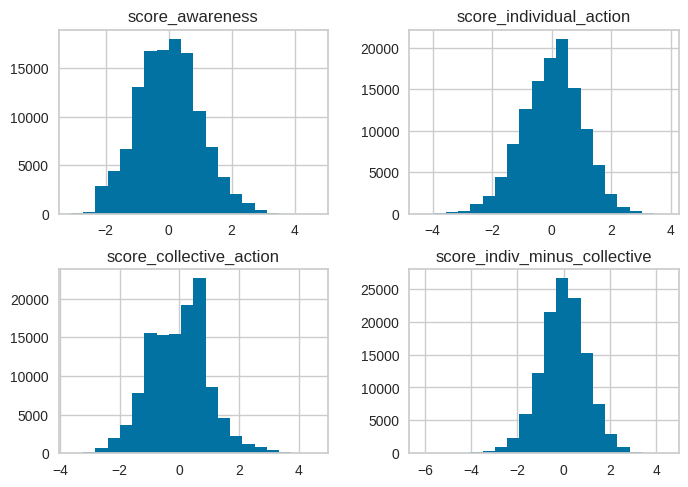

In [15]:
survey_df[['score_awareness', 'score_individual_action', 'score_collective_action', 'score_indiv_minus_collective']].hist(bins=20)


#### Distribution of Fossil Production Dependence

We can see that the fossil fuel rents as share of GDP (by country and year from 1990 to 2020) roughly follow a power law distribution.

Text(0.5, 1.0, 'Distribution of Fossil Fuel Rent across Countries')

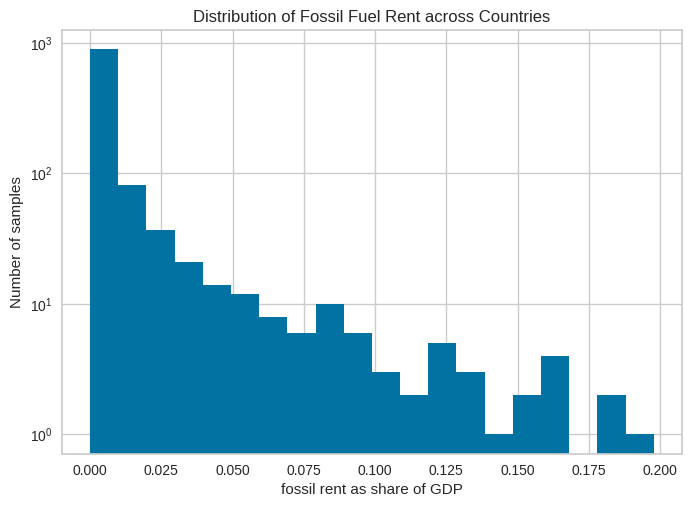

In [16]:
fossil_dependence_df['fossil_rent'].hist(bins=20, log=True)
plt.xlabel("fossil rent as share of GDP")
plt.ylabel("Number of samples")
plt.title('Distribution of Fossil Fuel Rent across Countries')

### Statistical Correlation Analysis

Variables:
- **Independent Variable**: Fossil fuel dependence
- **Dependent Variable**: Support for individual vs collective action?
- **Control**: Climate change awareness

### Identify Awareness, Public, and Collective Action variables

In [17]:
# Aggregated Scores
score_cols = ['score_awareness', 'score_individual_action', 'score_collective_action', 'score_indiv_minus_collective']

# Parameters relevant for later analysis.
most_params = ['NY.GDP.COAL.RT.ZS', 'NY.GDP.NGAS.RT.ZS',	'NY.GDP.PETR.RT.ZS', 'fossil_rent'] \
                + ['fossil_rent_log10', 'NY.GDP.PCAP.CD', 'gdp_log10'] \
                + score_cols \
                + ['education_years'] \
                + list(awareness_questions_weights.keys()) \
                + list(propaganda_questions_weights.keys()) \
                + list(collective_action_questions_weights.keys())
groupby_params = ['country_iso2', 'year']


In [18]:
# We could multiply the regional weight factors but it has next to no impact (doesn't make a difference though and the code is less readable)...
# adjusted = merged_df.groupby(['year', 'country_iso2']).apply(lambda x: np.ma.average(x['score_awareness'], weights=x['regional_weight_factor'], axis=0))
# adjusted

# Aggregate responses by country and year (because we don't have more fine-grained data on the economy-side).
aggregated_scores = merged_df.groupby(groupby_params)[most_params].agg(np.nanmean)
# Add fossil rent for country and year
aggregated_scores['fossil_rent'] = merged_df.groupby(groupby_params)['fossil_rent'].first()
# Drop values with missing target awareness
aggregated_scores = aggregated_scores[aggregated_scores['score_awareness'].notna()]
aggregated_scores = aggregated_scores.reset_index()

The following shows the Development of several Indicators assessed.

In [19]:
def plot_scores(df, questions, thick_questions, labels):
  for question in questions + thick_questions:
    mean_by_year = df.groupby('year')[question].mean()
    mean_by_year = mean_by_year.sort_index()
    label = labels[question] or question
    if question in thick_questions:
      plt.plot(mean_by_year, label=label, linewidth=5)
    else:
      plt.plot(mean_by_year, label=label)

  years = df['year'].unique().sort_values()
  plt.xlabel("year")
  plt.ylabel("Averaged, normalized response")
  plt.xticks(years)
  plt.legend(loc=(1.05, 0.425))

Text(0.5, 1.0, 'Support for awareness-related statements about environment')

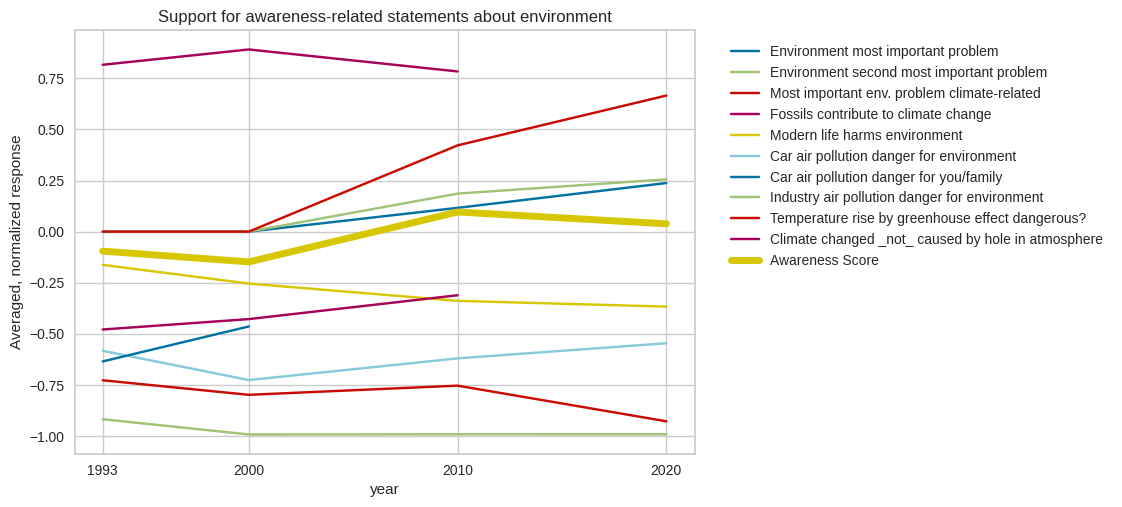

In [20]:
plot_scores(survey_df, list(awareness_questions_weights.keys()), ['score_awareness'], column_labels)
plt.title("Support for awareness-related statements about environment")

Text(0.5, 1.0, 'Support for individual action-related statements about environment')

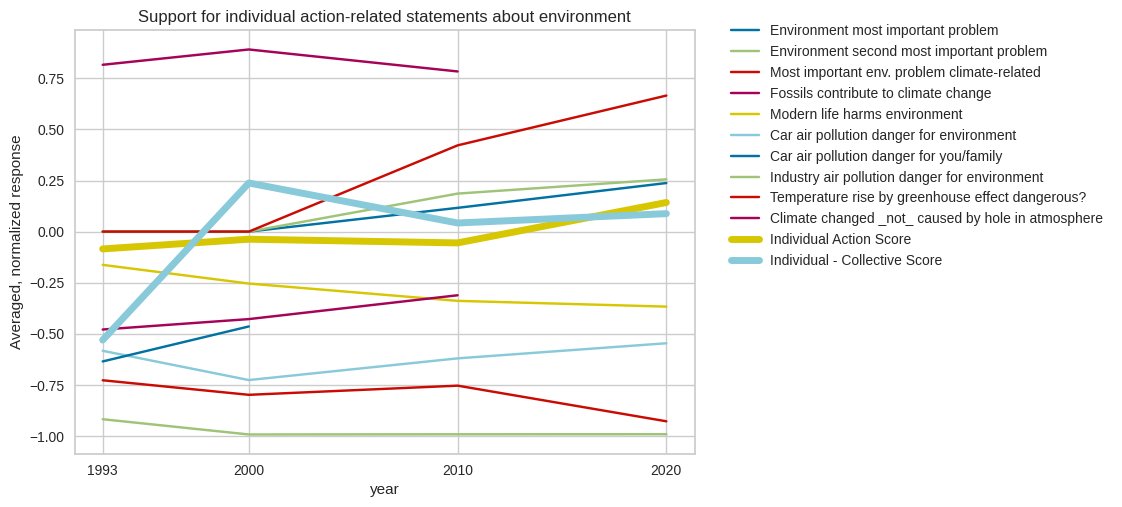

In [21]:
plot_scores(survey_df, list(awareness_questions_weights.keys()), ['score_individual_action', 'score_indiv_minus_collective'], column_labels)
plt.title("Support for individual action-related statements about environment")

Text(0.5, 1.0, 'Support for collective action-related statements about environment')

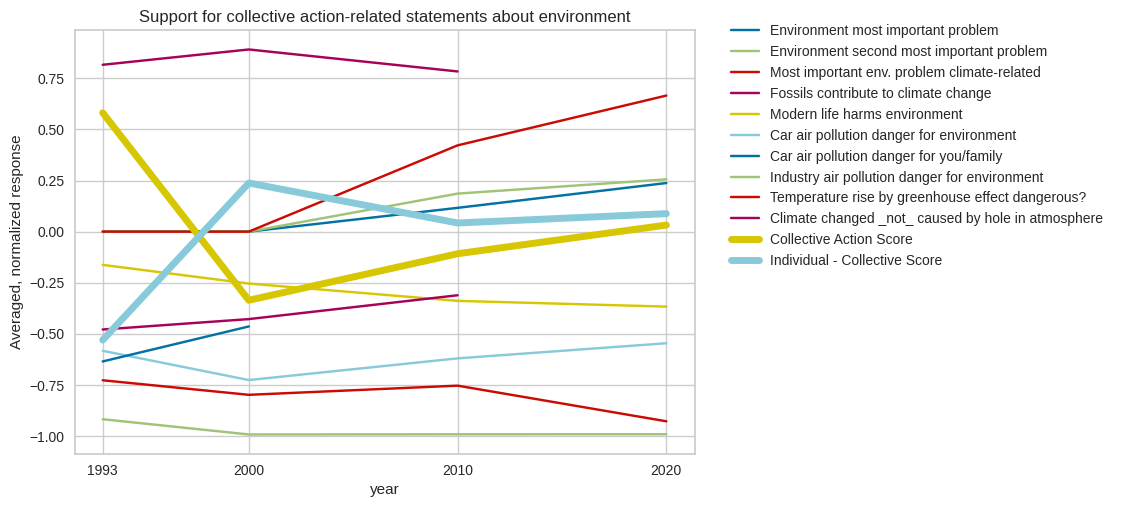

In [22]:
plot_scores(survey_df, list(awareness_questions_weights.keys()), ['score_collective_action', 'score_indiv_minus_collective'], column_labels)
plt.title("Support for collective action-related statements about environment")

### Correlation between different Indicators

Fossil Fuel Rent (log10) x Individual - Collective Score
- Kendall's Tau: -0.11760013438584747, p-value: 0.08398591534691141
- Linear Regression R²: 0.0015046512183127803
GDP per Capita (log10) x Individual - Collective Score
- Kendall's Tau: 0.10181818181818184, p-value: 0.13336309844895997
- Linear Regression R²: 0.06371649871417584
Fossil Fuel Rent (log10) x Awareness Score
- Kendall's Tau: 0.05312281932602076, p-value: 0.43504654140524823
- Linear Regression R²: 0.0017984699573120322
GDP per Capita (log10) x Awareness Score
- Kendall's Tau: 0.54989898989899, p-value: 5.212705726539077e-16
- Linear Regression R²: 0.4409212166798858


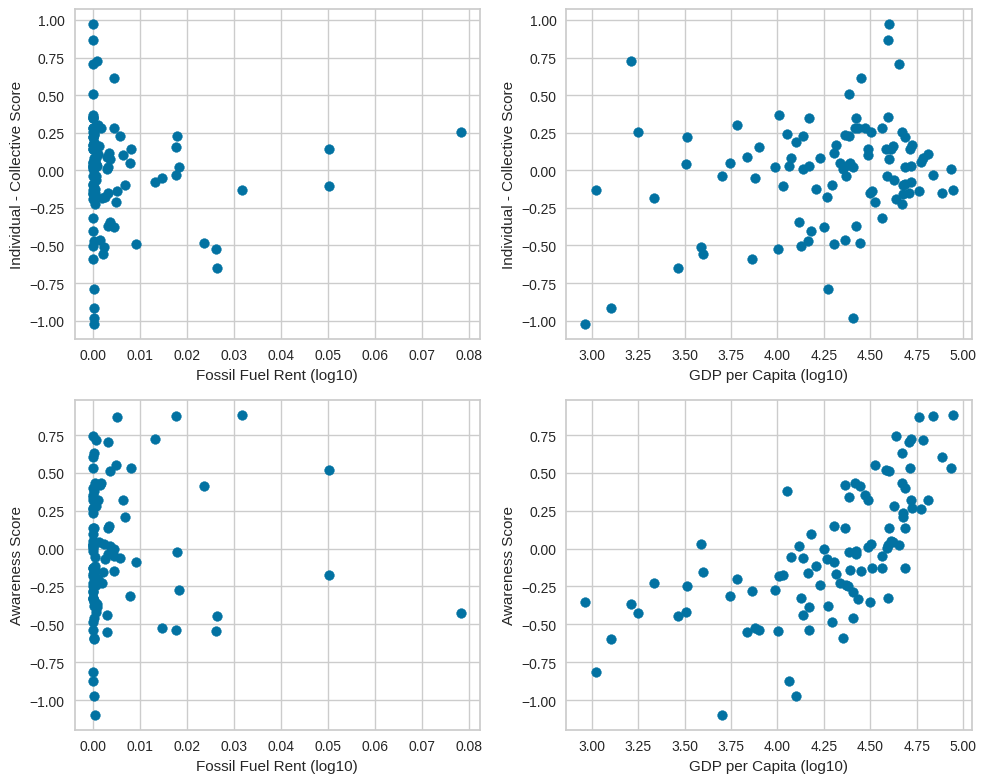

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

def plot_and_calculate_stats(ax, x, y, xlabel, ylabel, plot_title):
    # Scatter plot
    ax.scatter(x, y)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    print(plot_title)

    # Calculate Kendall's Tau
    tau, p_value = stats.kendalltau(x, y)
    print(f"- Kendall's Tau: {tau}, p-value: {p_value}")

    # Perform linear regression
    x = np.array(x).reshape(-1, 1)
    model = LinearRegression().fit(x, y)
    y_pred = model.predict(x)
    r2 = r2_score(y, y_pred)
    print(f"- Linear Regression R²: {r2}")

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

plot_and_calculate_stats(axs[0, 0], aggregated_scores['fossil_rent_log10'], aggregated_scores['score_indiv_minus_collective'],
                         column_labels['fossil_rent_log10'], column_labels['score_indiv_minus_collective'], 
                         f"{column_labels['fossil_rent_log10']} x {column_labels['score_indiv_minus_collective']}")

plot_and_calculate_stats(axs[0, 1], aggregated_scores['gdp_log10'], aggregated_scores['score_indiv_minus_collective'],
                         column_labels['gdp_log10'], column_labels['score_indiv_minus_collective'], 
                         f"{column_labels['gdp_log10']} x {column_labels['score_indiv_minus_collective']}")

plot_and_calculate_stats(axs[1, 0], aggregated_scores['fossil_rent_log10'], aggregated_scores['score_awareness'],
                         column_labels['fossil_rent_log10'], column_labels['score_awareness'], 
                         f"{column_labels['fossil_rent_log10']} x {column_labels['score_awareness']}")

plot_and_calculate_stats(axs[1, 1], aggregated_scores['gdp_log10'], aggregated_scores['score_awareness'],
                         column_labels['gdp_log10'], column_labels['score_awareness'], 
                         f"{column_labels['gdp_log10']} x {column_labels['score_awareness']}")

plt.tight_layout()
plt.show()

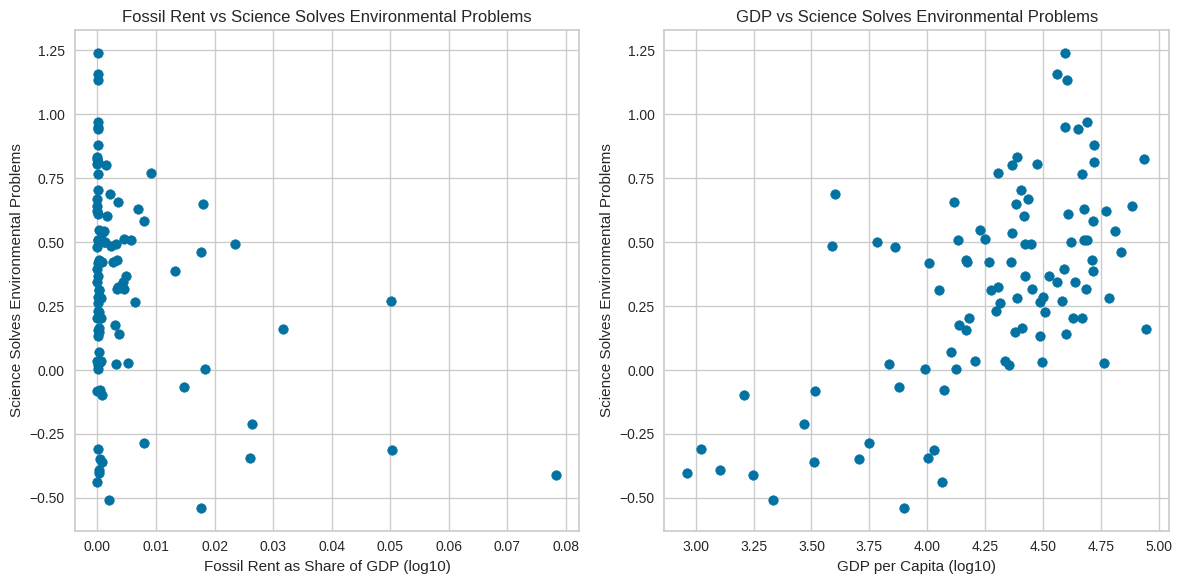

In [24]:
# Create a 1x2 grid of subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Scatter plot in the first subplot
axs[0].scatter(aggregated_scores['fossil_rent_log10'], aggregated_scores['science_solves_env_problems'])
axs[0].set_xlabel('Fossil Rent as Share of GDP (log10)')
axs[0].set_ylabel('Science Solves Environmental Problems')
axs[0].set_title('Fossil Rent vs Science Solves Environmental Problems')

# Scatter plot in the second subplot
axs[1].scatter(aggregated_scores['gdp_log10'], aggregated_scores['science_solves_env_problems'])
axs[1].set_xlabel('GDP per Capita (log10)')
axs[1].set_ylabel('Science Solves Environmental Problems')
axs[1].set_title('GDP vs Science Solves Environmental Problems')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

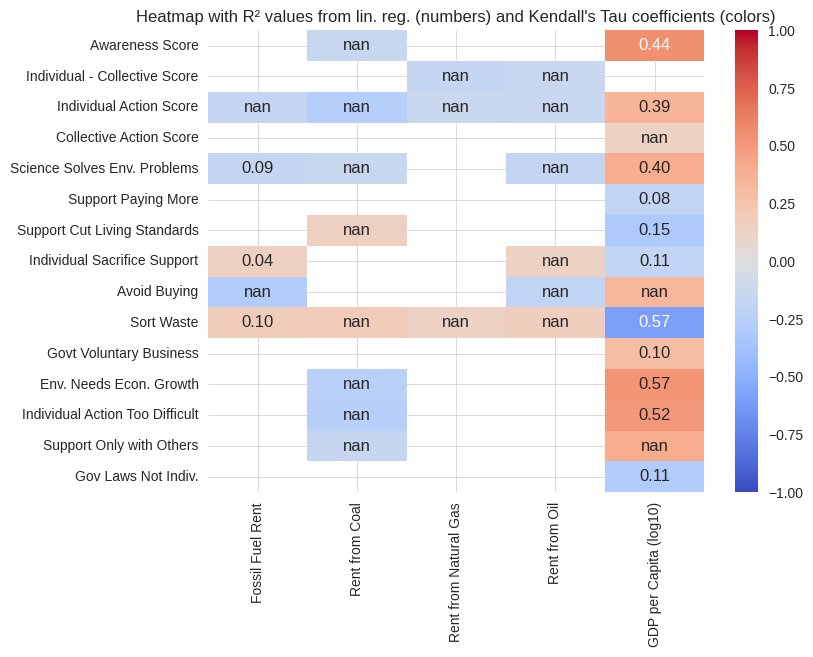

In [25]:
fields = ['score_awareness', 'score_indiv_minus_collective', 'score_individual_action', 'score_collective_action', 'science_solves_env_problems',
          'support_indiv_pay_more', 'support_cut_living_standards', 'indiv_support_sacrifice',
          'indiv_avoid_buying', 'indiv_sort_waste', 'gov_voluntary_business', 'env_needs_econ_growth',
          'indiv_action_too_difficult', 'support_only_with_others', 'gov_laws_not_indiv'] + \
         ['fossil_rent', 'NY.GDP.COAL.RT.ZS', 'NY.GDP.NGAS.RT.ZS', 'NY.GDP.PETR.RT.ZS', 'gdp_log10']

correlation_matrix = aggregated_scores[fields].corr(
    method=lambda x, y: stats.kendalltau(x, y)[0] if stats.kendalltau(x, y)[1] < 0.05 else np.nan
)[
    ['fossil_rent', 'NY.GDP.COAL.RT.ZS', 'NY.GDP.NGAS.RT.ZS', 'NY.GDP.PETR.RT.ZS', 'gdp_log10']
]

correlation_matrix = correlation_matrix.iloc[:-5, :]  

# Calculate R² values
r_squared_matrix = pd.DataFrame(index=correlation_matrix.index, columns=correlation_matrix.columns)
for row in correlation_matrix.index:
    for col in correlation_matrix.columns:
        if not pd.isna(correlation_matrix.loc[row, col]):
            slope, intercept, r_value, p_value, std_err = stats.linregress(aggregated_scores[row], aggregated_scores[col])
            if p_value < 0.05:
                r_squared_matrix.loc[row, col] = r_value**2


# Rename the columns and index
correlation_matrix = correlation_matrix.rename(columns=column_labels, index=column_labels)
r_squared_matrix = r_squared_matrix.rename(columns=column_labels, index=column_labels)

# Plot heatmap with R² values
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=r_squared_matrix, cmap='coolwarm', vmin=-1, vmax=1, center=0, fmt='.2f')
plt.grid(which="major", linewidth=.5)

plt.title("Heatmap with R² values from lin. reg. (numbers) and Kendall's Tau coefficients (colors)")

plt.show()

### Comparison of various other statistical methods

We have the problem of little data. The data does not show clear trends, as can be seen in the scatter plots above. In consequence, the results are very different for each run.

In [26]:
# The following assess different models to explain awareness by fossil rent and logged gdp.
# The results show that there is no correlation (R² value below 0 for all tests).

# Pycaret is a tool to that can compare statistical models and all sorts of nice things, e.g. visualizations.
# In the following a set of models is assessed.
import pycaret.regression as reg

exp1 = reg.setup(
  data=aggregated_scores[['fossil_rent_log10', 'score_awareness', 'gdp_log10', 'education_years']], # log(GDP per capita) is included as a control variable, as done by Knight (2018).
  target='score_awareness',
)

# Don't use more than 12 seconds for evaluating a model.
model = reg.compare_models(budget_time=0.2)
# Show interactive dashboard about best model (e.g. prediction error and feature importance).
# reg.evaluate_model(model)

,Description,Value
0,Session id,4995
1,Target,score_awareness
2,Target type,Regression
3,Original data shape,"(100, 4)"
4,Transformed data shape,"(100, 4)"
5,Transformed train set shape,"(70, 4)"
6,Transformed test set shape,"(30, 4)"
7,Numeric features,3
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
ada,AdaBoost Regressor,0.2410,0.0860,0.2831,0.2393,0.1789,2.5058,0.0250
knn,K Neighbors Regressor,0.2591,0.1131,0.3167,0.1602,0.2040,1.6083,0.0130
lightgbm,Light Gradient Boosting Machine,0.2470,0.0975,0.3036,0.0840,0.1757,3.6424,9.0740
rf,Random Forest Regressor,0.2465,0.0883,0.2905,0.0631,0.1801,3.3639,0.0470
gbr,Gradient Boosting Regressor,0.2469,0.0902,0.2955,0.0276,0.1882,4.8905,0.0210
lr,Linear Regression,0.2673,0.1050,0.3162,-0.0224,0.2098,2.9442,0.3800
lar,Least Angle Regression,0.2673,0.1050,0.3162,-0.0224,0.2098,2.9442,0.0070
ridge,Ridge Regression,0.2613,0.1048,0.3169,-0.0260,0.2118,2.8326,0.0070
br,Bayesian Ridge,0.2619,0.1047,0.3167,-0.0304,0.2107,2.9707,0.0070
huber,Huber Regressor,0.2713,0.1078,0.3206,-0.0541,0.2132,2.9889,0.0100


In [ ]:
reg.evaluate_model(model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…